In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize




In [79]:
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix

from keras.preprocessing.sequence import pad_sequences

In [80]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mvale\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mvale\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [81]:
df=pd.read_csv('text_emotions.csv')

In [82]:
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [83]:
df.drop(columns='Unnamed: 0',inplace=True)

In [84]:
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [85]:
print(f'The shape of data is: {df.shape}')

The shape of data is: (416809, 2)


In [86]:
df.duplicated().sum()

686

In [87]:
df=df.drop_duplicates()

In [88]:
df.duplicated().sum()

0

In [89]:
emotion_map={
0: 'sadness',
1: 'joy',
2: 'love',
3: 'anger',
4: 'fear',
5: 'surprise'


}
df['label']=df['label'].map(emotion_map)

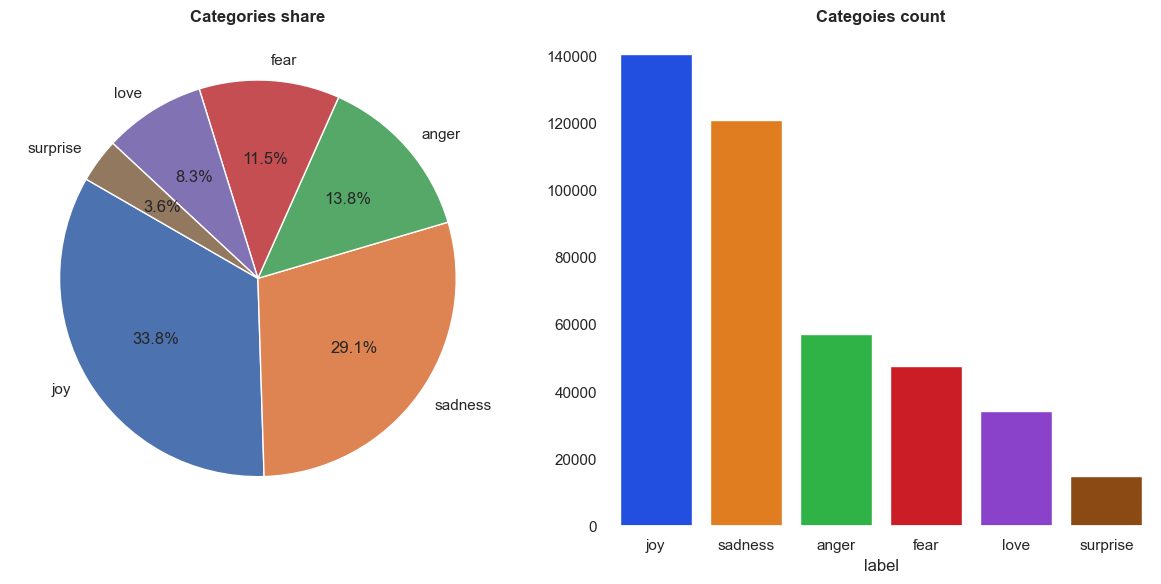

In [90]:
count=df['label'].value_counts()
background_color='w'
sns.set_theme(style="darkgrid",rc={"axes.facecolor": background_color,'figure.facecolor':background_color})

fig,axs=plt.subplots(1,2,figsize=(12,6),facecolor=background_color)

palette=sns.color_palette("bright",len(count))
sns.set_palette(palette)
axs[0].pie(count,labels=count.index,autopct='%1.1f%%',startangle=150)
axs[0].set_title('Categories share', fontsize=12,fontweight='bold')

sns.barplot(x=count.index,y=count.values,ax=axs[1],palette=palette)
axs[1].set_title('Categoies count',fontsize=12,fontweight='bold')

plt.tight_layout()

plt.show()

In [91]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [92]:
def replace_chat_words(text):
    words=text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

df['text'] = df['text'].apply(replace_chat_words)

In [93]:
df['text']=df['text'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x))
df.head()

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


In [94]:
stop=stopwords.words('english')
df['text']=df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


In [95]:
df['text']=df['text'].str.lower()
df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


In [96]:
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


In [97]:
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
print(df.head())


                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


In [98]:
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


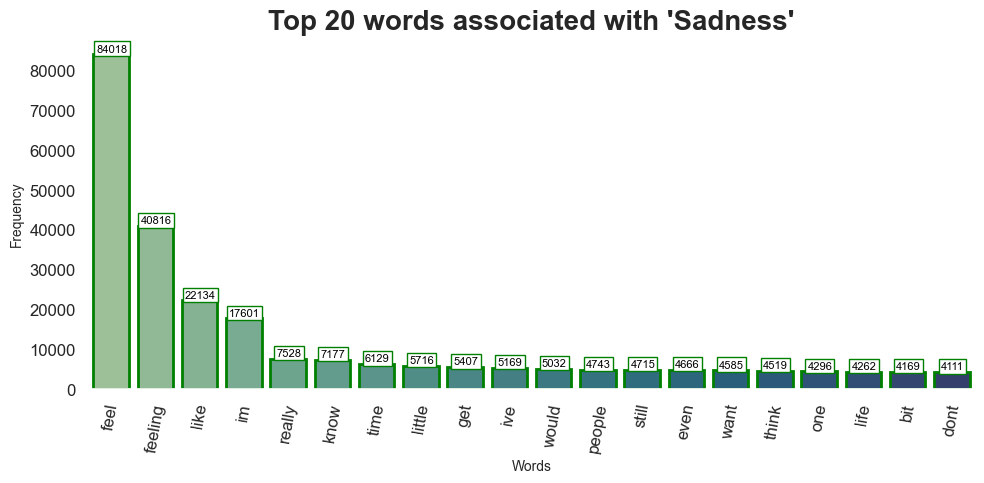

In [99]:
love_texts = df[df['label'] == 'sadness']['text']


words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)


top_20_words = dict(word_freq.most_common(20))


background_color = 'w'
sns.set_theme(style="darkgrid", rc={"axes.facecolor": background_color})


plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='crest', edgecolor='green', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=8, padding=6, position=(0.5, 0.5),bbox={"boxstyle": "square", "pad": 0.2, "facecolor": "white", "edgecolor": "green", "linewidth": 1, "alpha": 1})
plt.title("Top 20 words associated with 'Sadness'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

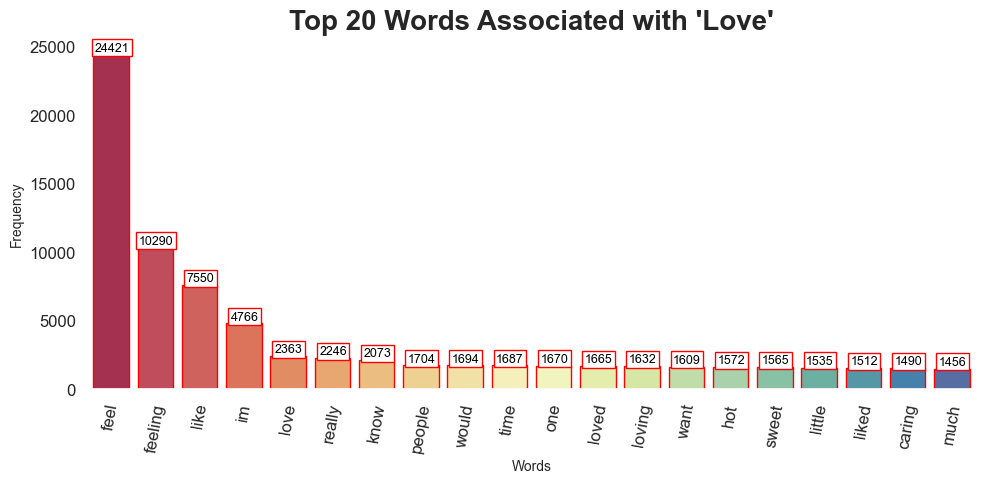

In [100]:
love_texts = df[df['label'] == 'love']['text']


words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)


top_20_words = dict(word_freq.most_common(20))


background_color = 'white'
sns.set_theme(style="darkgrid", rc={"axes.facecolor": background_color})


plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='Spectral', edgecolor='red', linewidth=1)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "square", "pad": 0.2, "facecolor": "white", "edgecolor": "red", "linewidth": 1, "alpha": 1})
plt.title("Top 20 Words Associated with 'Love'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

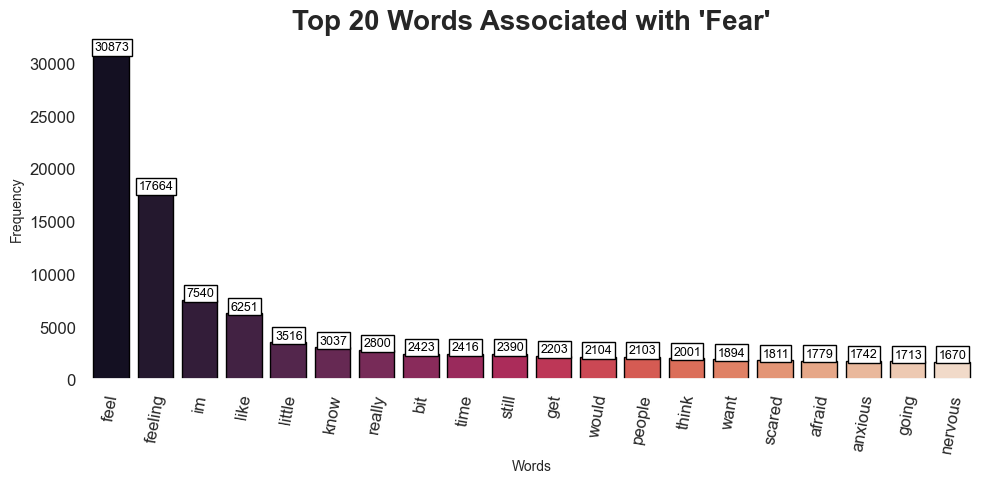

In [101]:
fear_texts = df[df['label'] == 'fear']['text']


words = [word.lower() for text in fear_texts for word in word_tokenize(text)]
word_freq = Counter(words)


top_20_words = dict(word_freq.most_common(20))


background_color = 'white'
sns.set_theme(style="darkgrid", rc={"axes.facecolor": background_color})


plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='rocket', edgecolor='black', linewidth=1)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "square", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 1, "alpha": 1})
plt.title("Top 20 Words Associated with 'Fear'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

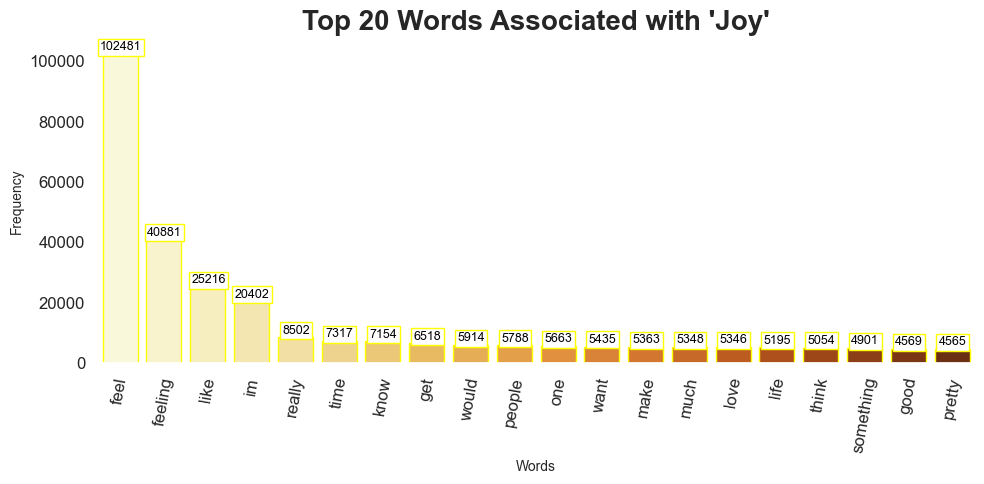

In [102]:
joy_texts = df[df['label'] == 'joy']['text']


words = [word.lower() for text in joy_texts for word in word_tokenize(text)]
word_freq = Counter(words)


top_20_words = dict(word_freq.most_common(20))


background_color = 'white'
sns.set_theme(style="darkgrid", rc={"axes.facecolor": background_color})


plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='YlOrBr', edgecolor='yellow', linewidth=1)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "square", "pad": 0.2, "facecolor": "white", "edgecolor": "yellow", "linewidth": 1, "alpha": 1})
plt.title("Top 20 Words Associated with 'Joy'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

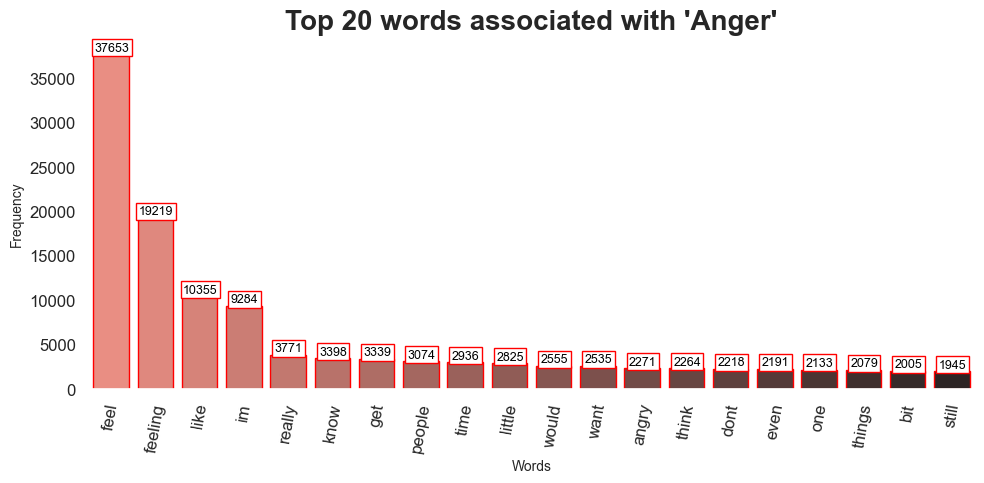

In [103]:
anger_texts = df[df['label'] == 'anger']['text']


words = [word.lower() for text in anger_texts for word in word_tokenize(text)]
word_freq = Counter(words)


top_20_words = dict(word_freq.most_common(20))


background_color = 'white'
sns.set_theme(style="darkgrid", rc={"axes.facecolor": background_color})


plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='dark:salmon_r', edgecolor='red', linewidth=1)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "square", "pad": 0.2, "facecolor": "white", "edgecolor": "red", "linewidth": 1, "alpha": 1})
plt.title("Top 20 words associated with 'Anger'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

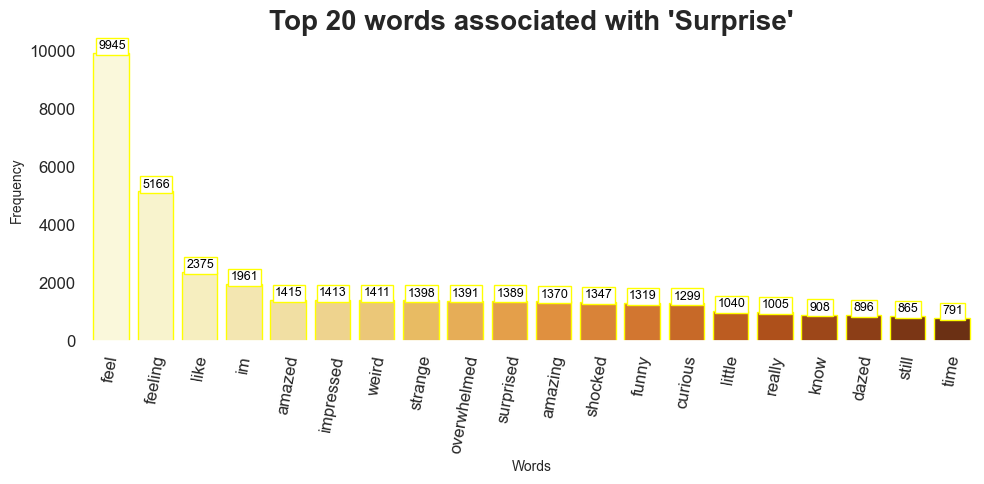

In [104]:
surprise_texts = df[df['label'] == 'surprise']['text']


words = [word.lower() for text in surprise_texts for word in word_tokenize(text)]
word_freq = Counter(words)


top_20_words = dict(word_freq.most_common(20))


background_color = 'white'
sns.set_theme(style="darkgrid", rc={"axes.facecolor": background_color})


plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='YlOrBr', edgecolor='yellow', linewidth=1)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "square", "pad": 0.2, "facecolor": "white", "edgecolor": "yellow", "linewidth": 1, "alpha": 1})
plt.title("Top 20 words associated with 'Surprise'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [105]:
# Re-mapping the mapping dictionary
label_mapping = {'sadness':0,'joy':1,'love':2,'anger':3,'fear':4,'surprise':5}
df['label']=df['label'].map(label_mapping)

In [106]:
df.head()

,text,label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


In [107]:
from sklearn.model_selection import train_test_split
X=df['text']
y=df['label']

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print("The shape of X_train is",X_train.shape)
print("The shape of X_test is",X_test.shape)
print("The shape of y_train is",y_train.shape)
print("The shape of y_test is",y_test.shape)

The shape of X_train is (332898,)
The shape of X_test is (83225,)
The shape of y_train is (332898,)
The shape of y_test is (83225,)


In [108]:
tokenizer=Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

In [109]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences=tokenizer.texts_to_sequences(X_test)

In [110]:
from keras.preprocessing.sequence import pad_sequences

In [111]:
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen): ",maxlen)

Maximum sequence length (maxlen):  79


In [112]:
X_train_padded=pad_sequences(X_train_sequences,maxlen=maxlen,padding='post')
X_test_padded=pad_sequences(X_test_sequences,maxlen=maxlen,padding='post')

In [113]:
print("X_train_padded:")
print(X_train_padded)
print("X_test_padded:")
print(X_test_padded)

X_train_padded:
[[2513   13 2430 ...    0    0    0]
 [   1  845  392 ...    0    0    0]
 [   1  659   83 ...    0    0    0]
 ...
 [1453   24    1 ...    0    0    0]
 [   6   13  262 ...    0    0    0]
 [ 171  102    2 ...    0    0    0]]
X_test_padded:
[[   6  213  146 ...    0    0    0]
 [   2  223   32 ...    0    0    0]
 [ 189   11    1 ...    0    0    0]
 ...
 [   1  563 1097 ...    0    0    0]
 [   4  303 8707 ...    0    0    0]
 [   1    3  105 ...    0    0    0]]


In [114]:
input_size=np.max(X_train_padded)+1
input_size

60000

In [117]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, BatchNormalization, Dropout

In [120]:
# Modeling data  - adding several layers

model = Sequential()

model.add(Embedding(input_dim=input_size,output_dim=100,input_shape=(79,)))

model.add(Bidirectional(LSTM(128)))

model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(6,activation='softmax'))

In [121]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 79, 100)        │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,252,358 (23.85 MB)

 Trainable params: 6,251,846 (23.85 MB)

 Non-trainable params: 512 (2.00 KB)

In [123]:
history=model.fit(X_train_padded,y_train,epochs=1,batch_size=32,validation_data=(X_test_padded,y_test),callbacks=[EarlyStopping(patience=3)])

10404/10404 ━━━━━━━━━━━━━━━━━━━━ 1662s 160ms/step - accuracy: 0.9387 - loss: 0.1033 - val_accuracy: 0.9399 - val_loss: 0.0927


In [124]:
model.evaluate(X_test_padded,y_test)

2601/2601 ━━━━━━━━━━━━━━━━━━━━ 98s 38ms/step - accuracy: 0.9409 - loss: 0.0915


[0.09274091571569443, 0.9399098753929138]

In [125]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred,axis=1)

2601/2601 ━━━━━━━━━━━━━━━━━━━━ 77s 29ms/step


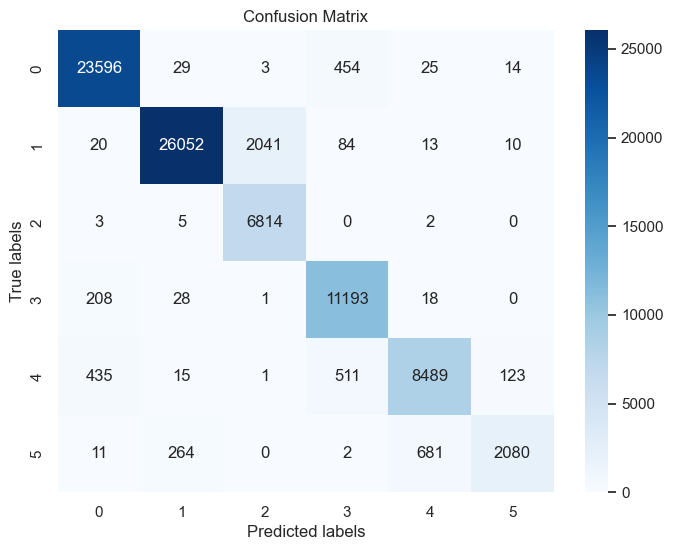

In [126]:
conf_mat = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True,fmt='d',cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()